### DA-PredGAN Predictions

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ACSE-9')

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import time
from collections import deque

import joblib
import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

     |████████████████████████████████| 59.5 MB 45 kB/s 
     |████████████████████████████████| 495 kB 52.0 MB/s 
     |████████████████████████████████| 3.1 MB 36.7 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 3.0 MB 45.9 MB/s 
     |████████████████████████████████| 251 kB 56.9 MB/s 
     |████████████████████████████████| 1.3 MB 36.2 MB/s 
     |████████████████████████████████| 294 kB 51.9 MB/s 
     |████████████████████████████████| 142 kB 62.9 MB/s 


### loading in enhanced and scaled dataset, scalers and preparing data

In [ ]:
enhanced_data_scaled = joblib.load('output_files/enhanced_data_scaled_410.pkl')
scaler_pca = joblib.load('output_files/scaler_pca_410.pkl')

pca = joblib.load('output_files/pca_compress_410.pkl')

scaler_std = joblib.load('output_files/scaler_std_410.pkl')
scaler_x = joblib.load('output_files/scaler_x_410.pkl')
scaler_y = joblib.load('output_files/scaler_y_410.pkl')
scaler_z = joblib.load('output_files/scaler_z_410.pkl')
scaler_enhanced = joblib.load('output_files/CO2_scaler_minmax_410.pkl')

CO2data = joblib.load('output_files/CO2data_410.pkl') #snapshot matrix
CO2_sensor_all = joblib.load('output_files/sensor_CO2_all.pkl')
X_train_pca = joblib.load('output_files/pod_coefficients_410.pkl')
CO2_sensor = CO2_sensor_all[:410,:]

In [ ]:
X_train_scaled = enhanced_data_scaled.copy()
print(X_train_scaled.shape)
codings_size = X_train_scaled.shape[1] #50

(410, 50)


### Ensuring the enhanced data is scaled between [-1, 1]

POD coefficients and sensor data are scaled seperately but both [-1,1]

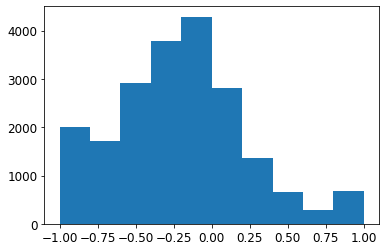

In [ ]:
'''
  Histogram showing the frequency distribution; ensuring scaling between [-1,1]
'''
plt.hist(X_train_scaled.flatten())
X_test_scaled = X_train_scaled.copy()

In [ ]:
def ReadData(filename):
  ''' 
    ReadData function takes in a file and returns the data
    Parameters
    ----------

    filename : str
      .dat file

    output: array
      data of the file

  '''
  output = []
  sf = open(filename, 'r')
  data = sf.readlines()
  for i in range(0,len(data)):
    x = str.split(data[i])
    y = [float(v) for v in x]
    output.append(y)

  output = np.transpose(output)
  return output

In [ ]:
CO2_experiment = ReadData('output_files/CO2_Experiment.dat')
CO2_timevals = ReadData('output_files/ClarenceCentre/TimeVTU.dat')

In [ ]:
def concat_timesteps(X_train, ntimes, step):
  '''
    The function takes in a 2D array, picks 9 time levels at a time and skips time levels if needed.  
    Parameters
    ----------

    X_train : 2D array
      Scaled enhanced array - (Time levels, No. reduced parameters)

    ntimes : int
      Number of consective outputs from the GAN

    step : int
      size of step to skip data
  '''
  
  X_train_concat = []
  for i in range(len(X_train) - ntimes*step):
      X_train_concat.append(X_train[i:i+ntimes*step:step])
  return np.array(X_train_concat) 

In [ ]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

X_train_concat = concat_timesteps(X_test_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("X_train_concat_flatten: ", X_train_concat_flatten.shape)

X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

X_train_concat:  (401, 9, 50)
X_train_concat_flatten:  (401, 450)
X_train_4d:  (401, 9, 50, 1)


Loading model

In [ ]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model('output_files/GAN_model_410.h5', compile=False).layers

In [ ]:
'''
  Setting hyper-parameters
'''
np.random.seed(42)
tf.random.set_seed(42)
npredict = 8
latent_space = 50
noise = tf.random.normal(shape=[npredict, latent_space])
pca_size = 43 # num of POD coefficients

Assimilate data with the GAN

In [ ]:
def enhanced_sse_loss(real_coding, gen_output):
    '''
      This function calculates the loss from the generated generator output
      with reference to the training dataset
      Parameters
      ----------

      real coding : array
        batch of the training dataset
      
      gen_output : array
        output with respect to input latent values

      returns
      ---------
      enhanced_loss : float32
        loss given the error between generator output and real coding

    '''
    inp = tf.reshape(real_coding, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    out = tf.reshape(gen_output, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    
    enhanced_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return enhanced_loss

def obs_sse_loss(real_coding, gen_output):
    '''
      This function calculates the loss from the only the sensor locations
      Parameters
      ----------

      real coding : array
        batch of the training dataset
      
      gen_output : array
        output with respect to input latent values

      returns
      ---------
      obs_loss : float32
        loss given the error between the generated sensor locations values
        and the corresponding observations
        
    '''
    inp = tf.reshape(real_coding, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    out = tf.reshape(gen_output, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    
    obs_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return obs_loss

def optimize_coding_forward_only(latent_values, real_coding, epochs=1000):
    '''
      This function performs a forward pass, optimising the latent values
      with respect to the enhanced loss
      Parameters
      ----------

      latent_values : array (1,50)
        latent values for generating the generator output
      
      real_coding : array
        batch of the training dataset

      epochs : int (optional)
        determines the number of optimisation steps that occur

      returns
      ---------
      latent_values : array (1,50)
        optimised latent values
      
      loss : float32
        mean squared error difference
        
    '''
    optimizer = tf.keras.optimizers.Nadam(5e-3, 0.7, 0.999)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            enhanced_loss = enhanced_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])  
            obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])

            loss = enhanced_loss #+ obs_loss

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, enhanced_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_forward(optimizer, latent_values, real_coding))
         
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

def optimize_coding_LastForward(latent_values, real_coding, epochs=1000):
    '''
        This function performs the forward pass, optimising the latent values
        with respect to the enhanced loss
        Parameters
        ----------

        latent_values : array (1,50)
          latent values for generating the generator output
        
        real_coding : array
          batch of the training dataset

        epochs : int (optional)
          determines number of optimisation steps occur

        returns
        ---------
        latent_values : array (1,50)
          optimised latent values
        
        loss : float32
          mean squared error difference
        
    '''
    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)

    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            enhanced_loss = enhanced_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])  
            obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])

            loss = enhanced_loss

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, enhanced_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_forward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def optimize_coding_forward(latent_values, real_coding, epochs=1000):
    '''
      This function performs a forward pass, optimising the latent values
      with respect to the enhanced loss and observation loss
      Parameters
      ----------

      latent_values : array (1,50)
        latent values for generating the generator output
      
      real_coding : array
        batch of the training dataset

      returns
      ---------
      latent_values : array (1,50)
        optimised latent values
      
      loss : float32
        mean squared error difference
        
    '''
    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            enhanced_loss = enhanced_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            loss = enhanced_loss + obs_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, enhanced_loss, obs_loss
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_forward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def optimize_coding_backward(latent_values, real_coding, epochs=1000):
    '''
      This function performs a backward pass, optimising the latent values
      with respect to the enhanced loss and obs loss
      Parameters
      ----------

      latent_values : array (1,50)
        latent values for generating the generator output
      
      real_coding : array
        batch of the training dataset

      returns
      ---------
      latent_values : array (1,50)
        optimised latent values
      
      loss : float32
        mean squared error difference
        
    '''
    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)
    
    @tf.function
    # def opt_step_backward(optimizer, latent_values, real_coding, obs_data):
    def opt_step_backward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 
            enhanced_loss = enhanced_sse_loss(real_coding, gen_output[:,1:,:,:])   
            obs_loss = obs_sse_loss(real_coding, gen_output[:,1:,:,:])   
            loss = enhanced_loss + obs_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, enhanced_loss, obs_loss 
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_backward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

Generate Data for Test Case </br>


In [ ]:
'''
  Parameter to toggle if want to use experimental test case:
  if yes, experimental_obs = True, or False to use Fluidity CFD observations
'''
experimental_obs = False

### inserting first 14 experimental data into real_coding
DA_times = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780]
X_sensor_scaled = X_test_scaled[:,-7:]
X_sensor_unscaled = scaler_enhanced.inverse_transform(X_sensor_scaled)
print(X_sensor_unscaled.shape)

CO2_exp = CO2_experiment[1:,0:].T

X_sensor = X_sensor_unscaled.copy()

inp_cnt = 0
for i in range(900):
  if i in DA_times:
    idx = int(i/2) #every time step is ~2s
    X_sensor[idx] = CO2_exp[inp_cnt]
    inp_cnt += 1

# print(X_sensor[330])
print(np.allclose(X_sensor[120], CO2_exp[4]))
# print(np.allclose(X_sensor[1], X_sensor_unscaled[1]))

from sklearn.preprocessing import MinMaxScaler
DA_scaler = MinMaxScaler((-1,1))
X_obs_data = DA_scaler.fit_transform(X_sensor)
#X_obs_data.max()

(410, 7)
True


In [ ]:
X_test_scaled_pod = X_test_scaled[:,:43]
X_test_scaled_obs = np.concatenate([X_test_scaled_pod, X_obs_data], axis=1)
X_train_concat_obs = concat_timesteps(X_test_scaled_obs, ntimes, step)

In [ ]:
forward_steps = 447 
# making predictions up to the complete 455 time levels
time_steps = forward_steps + (ntimes-1) 

# peripheral/neighbouring nodes of sensor locations
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

In [ ]:
# Initial conditions

# Calculate the weights
# Delta variables 
delta_obs = 120
delta_pod = 2

# POD coefficients
weight_pod = 0.005*pca.singular_values_/pca.singular_values_.sum()
weight_pod = tf.constant(weight_pod, dtype=tf.float32)

print('weight_pod: ', weight_pod, end='\n\n')

# Observed data
weight_obs = 0.5*((delta_pod/delta_obs)**2)*ntimes #increase this value

print('weight_obs', weight_obs, end='\n\n')

weight_pod:  tf.Tensor(
[8.95549136e-04 6.87052787e-04 3.61452985e-04 3.05079913e-04
 2.11701394e-04 1.99069182e-04 1.75359120e-04 1.70242463e-04
 1.50240885e-04 1.32018919e-04 1.25000573e-04 1.17453004e-04
 1.03867380e-04 9.59952158e-05 9.05701963e-05 8.25092720e-05
 7.86452074e-05 7.01978570e-05 6.70535810e-05 6.16597754e-05
 5.90184281e-05 5.33225502e-05 5.15014690e-05 5.06396245e-05
 4.60649026e-05 4.26181687e-05 4.08375854e-05 3.96352261e-05
 3.77834986e-05 3.73248986e-05 3.46608031e-05 3.29974573e-05
 3.17866288e-05 3.13663841e-05 2.99375024e-05 2.88857736e-05
 2.75469665e-05 2.66789157e-05 2.51995207e-05 2.38089251e-05
 2.32732109e-05 2.26611355e-05 2.17315956e-05], shape=(43,), dtype=float32)

weight_obs 0.00125



Run data assimilation

In [ ]:
'''
  The process of amalgamating Data Assimilation with the predictive GAN follows a similar algorithmic process.
  Instead, it contains both forward and backward march, to gain realism of the initial or prior conditions
  previous to the sensor observations we have.
  Regarding the algorithm, it follows the optimisation step for the first next step prediction -> then proceeds
  to predict further in time.
  Specific details are highlighted in the thesis report.
'''

np.random.seed(0)
tf.random.set_seed(0)


# initialising lists
list_X_predict_forward = []
list_X_predict_backward = []
list_relax = []
forward_loss = []
backward_loss = []
forward_only_loss = []
relax = 1.0

# Maximum number of forward and backward consecutive passes set to 10
for j in range(10):    
    print(f'\nIteration {j}: forward and backward')
    latent_values_forward = []
    latent_values_backward = []
    
    #===========================================
    # Forward march 
    #===========================================
    print('-- Forward March --')
    
    loss_iteration = []
    
    # First forward march
    if j == 0: 

        n = 0

        # real coding representing a batch within the training set
        real_coding = X_train_concat[n]
        real_coding = real_coding[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        list_latent_values = []
        list_loss = []
        
        # making a next step prediction
        for _ in range(10):
            latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01)  
            latent_values = tf.Variable(latent_values) 
            # optimising latent values to minimise loss against the initial conditions (known solutions)
            latent_values, loss = optimize_coding_forward_only(latent_values, real_coding, epochs=5000)
            list_latent_values.append(latent_values)
            list_loss.append(loss)
        latent_values = list_latent_values[np.argmin(list_loss,axis=0)[0]]
        loss_iteration.append(list(map(float,list_loss[np.argmin(list_loss,axis=0)[0]])))
        print('Initial point losses: ', end='\n')
        for l in list_loss:
            print(['{0:1.2e}'.format(float(x)) for x in l])
        print()
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in list_loss[np.argmin(list_loss,axis=0)[0]]]), end='\n')        

        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        # One step prediction is the last of the forward pass
        gen_predict = X_predict_forward[-1] 
    
    # j!= 0 -> not the first forward pass
    else: 
        real_coding = X_predict_backward[0:(ntimes-1),:].copy()
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)  
        
        latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=100)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[0] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')
    
        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)

    for i in range(1, forward_steps):
        start = time.time()

        # This section refers to the decision made on which observation dataset being used for DA
        # If the experimental_obs toggle is set to True -> The first 14 values from experimental
        # data at physical sensor locations will be used.
        # If false -> observations from the CFD sensor locations will be used instead
        if experimental_obs == True:
            # if statement defines the point we begin a 'True' prediction & the march range
            if i <= 403 and (2*i in DA_times):
                real_coding = np.concatenate([real_coding[:, :pca_size], X_test_scaled_obs[i:(ntimes-1+i), pca_size:]], axis=1)
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

            # If observation data does not contain information for this time step
            # continue with next step prediction
            else:
                real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

        # If not using experimental observations for DA
        # using CFD Fluidity obs data instead
        else:        
            if i >= 403:
                real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

            else:
                real_coding = np.concatenate([real_coding[:, :pca_size], X_train_scaled[i:(ntimes-1+i), pca_size:]], axis=1)
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        # First pass
        if j == 0:    
            latent_values, loss = optimize_coding_forward_only(latent_values, real_coding, epochs=100)
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())      
        
        # If not first pass - apply relaxation factors
        else:
            latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=100)
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[i] + relax*latent_values.value())
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())

        real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_forward = np.array(X_predict_forward)
    if j == 0:
        X_predict_forward_first = X_predict_forward
    forward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
        

    #===========================================
    # Backward march
    #===========================================
    print('-- Backward March --')
    
    loss_iteration = []
    
    # Time stepping backward in time
    real_coding = X_predict_forward[time_steps-(ntimes-1):time_steps,:].copy()
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=100)
    if j != 0:
        latent_values = tf.Variable((1-relax)*latent_values_backward_old[0] + relax*latent_values.value())
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

    latent_values_backward.append(latent_values.value())
    X_predict_backward = deque(generator(latent_values).numpy().reshape(-1,codings_size))
    gen_predict = X_predict_backward[0]

    real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    # Same as described in the forward march section
    # with one amendment for the traversing BACKWARD in time
    for i in range(1, forward_steps): 
        if experimental_obs == True:
            if (time_steps-(ntimes-1) - i) <= 403 and (2*i in DA_times):
                real_coding = np.concatenate([real_coding[:, :pca_size], X_test_scaled_obs[time_steps-(ntimes-1) - i : (time_steps - i), pca_size:]], axis=1)      
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

            else:
                real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

        else:
            if time_steps-(ntimes-1) - i >= 403:
                real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

            else:
                real_coding = np.concatenate([real_coding[:, :pca_size], X_train_scaled[time_steps-(ntimes-1) - i : (time_steps - i), pca_size:]], axis=1)      
                real_coding = tf.constant(real_coding)
                real_coding = tf.cast(real_coding, dtype=tf.float32)

        start = time.time()

        latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=100)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_backward_old[i] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

        latent_values_backward.append(latent_values.value())
        gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[0]
        X_predict_backward.appendleft(gen_predict.copy())

        real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_backward = np.array(X_predict_backward)
    backward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
    
    # Save relaxation
    list_relax.append(relax)
    

    # plotting
    # inverse transforms of pca, scaling and splitting of fields/sensor values.
    split_inv = np.split(X_predict_backward, [43, ], axis=1)
    alpha = split_inv[0]
    sensor_CO2 = split_inv[-1]
    # undoing scaling pod coeffs
    alpha_unscaled = scaler_pca.inverse_transform(alpha)
    X_recovered = pca.inverse_transform(alpha_unscaled)
    X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)
    norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
    norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

    X_pca_inv = pca.inverse_transform(X_train_pca)
    real = np.split(X_pca_inv, [int(X_pca_inv.shape[-1]/4), int(X_pca_inv.shape[-1]/2), int(X_pca_inv.shape[-1]*(3/4)), ], axis=1)
    real_co2_ = scaler_std.inverse_transform(real[0])

    print("norm_co2_.min()", norm_co2_.min())
    print("norm_co2_.max()", norm_co2_.max())

    # POD coefficient convergence plot
    fig, ax = plt.subplots(5,2, figsize=[20,10])
    fig.tight_layout()
    for i in range(0, 10, 1):
      ax.flatten()[i].plot(X_train_pca[i+9, :10], '-o', label='real')
      ax.flatten()[i].plot(alpha_unscaled[i+9, :10], '-o', label='predicted')
      ax.flatten()[i].legend()
      ax.flatten()[i].set_xlabel('POD coefficient number') 
      ax.flatten()[i].grid()

    # Temporal plot at peripheral nodes (NOT sensor locs)
    fig1, ax1 = plt.subplots(4,2, figsize=[20,10])
    fig1.tight_layout()
    for i in range(8):
      ax1.flatten()[i].plot(norm_co2_[:410,locs[i]], '-')
      ax1.flatten()[i].plot(real_co2_[:410,locs[i]], '-')
      ax1.flatten()[i].legend(['prediction', 'real'])

    plt.show()

    # Update relaxation
    epsilon = 0.98
    loss_obs = (forward_loss[-1][-1] + backward_loss[-1][-1])/2 
    print(f'Loss obs: {loss_obs}')
    if j == 0:
        loss_obs_old = loss_obs        
        latent_values_forward_old = latent_values_forward.copy()
        latent_values_backward_old = latent_values_backward.copy()
        X_predict_backward_old = X_predict_backward.copy()

    else:
        print(f'Loss obs old: {loss_obs_old}')
        print(f'Relax old: {relax}, new ', end='')
        if (loss_obs - loss_obs_old*epsilon) < 0:
            loss_obs_old = loss_obs
            X_predict_backward_old = X_predict_backward.copy()
            latent_values_forward_old = latent_values_forward.copy()
            latent_values_backward_old = latent_values_backward.copy()

            relax *= 1.5
            if relax > 1.0: 
                relax = 1.0              
        else:
            relax *= 0.5
            if relax < 0.05: 
                print(relax)
                print('Converged!')
                # plot loss functions
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(forward_loss)), forward_loss[2:])
                ax.set_title('Forward loss')
                plt.grid()
                plt.legend(['Total loss','enhanced loss','Obs loss'])    
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(backward_loss)), backward_loss[2:])
                ax.set_title('Backward loss')
                plt.grid()
                plt.legend(['Total loss','enhanced loss','Obs loss'])
                break
            X_predict_backward = X_predict_backward_old
            latent_values_forward = latent_values_forward_old
            latent_values_backward = latent_values_backward_old

        print(relax) 
    
    list_X_predict_forward.append(X_predict_forward)
    list_X_predict_backward.append(X_predict_backward)
    

In [ ]:
#===========================================
# Last time stepping forward march
#===========================================
print('-- Last time Stepping Forward March --')

loss_iteration = []

real_coding = X_predict_backward[0:(ntimes-1),:].copy()
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)  

latent_values_only = tf.Variable(latent_values)
latent_values_only, loss = optimize_coding_forward_only(latent_values_only, real_coding, epochs=100)
loss_iteration.append(list(map(float,loss)))
print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

X_predict_forward_last = list(generator(latent_values_only).numpy().reshape(-1,codings_size))
gen_predict = X_predict_forward_last[-1]

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# Last full pass foward march in time
# process same as above
for i in range(1, forward_steps): 

    start = time.time()
    latent_values_only, loss = optimize_coding_forward_only(latent_values_only, real_coding, epochs=100)
    
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

    gen_predict = generator(latent_values_only).numpy().reshape(-1,codings_size)[-1]
    X_predict_forward_last.append(gen_predict.copy())

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:] 
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
X_predict_forward_last = np.array(X_predict_forward_last)
forward_only_loss.append(np.array(loss_iteration).mean(axis=0))
print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])


-- Last time Stepping Forward March --
Loss iteration 0: ['1.45e-03', '1.45e-03', '1.35e-03']
Loss iteration 1: ['1.19e-03', '1.19e-03', '1.29e-03'] - 1s
Loss iteration 2: ['1.00e-03', '1.00e-03', '1.88e-03'] - 1s
Loss iteration 3: ['7.89e-04', '7.89e-04', '2.48e-03'] - 1s
Loss iteration 4: ['6.71e-04', '6.71e-04', '3.17e-03'] - 1s
Loss iteration 5: ['6.18e-04', '6.18e-04', '2.95e-03'] - 1s
Loss iteration 6: ['5.98e-04', '5.98e-04', '2.96e-03'] - 1s
Loss iteration 7: ['5.61e-04', '5.61e-04', '2.91e-03'] - 1s
Loss iteration 8: ['4.92e-04', '4.92e-04', '2.49e-03'] - 1s
Loss iteration 9: ['4.51e-04', '4.51e-04', '2.32e-03'] - 1s
Loss iteration 10: ['4.00e-04', '4.00e-04', '2.04e-03'] - 1s
Loss iteration 11: ['3.56e-04', '3.56e-04', '1.73e-03'] - 1s
Loss iteration 12: ['3.32e-04', '3.32e-04', '1.53e-03'] - 1s
Loss iteration 13: ['3.28e-04', '3.28e-04', '1.41e-03'] - 1s
Loss iteration 14: ['3.32e-04', '3.32e-04', '1.19e-03'] - 1s
Loss iteration 15: ['3.35e-04', '3.35e-04', '8.87e-04'] - 1s


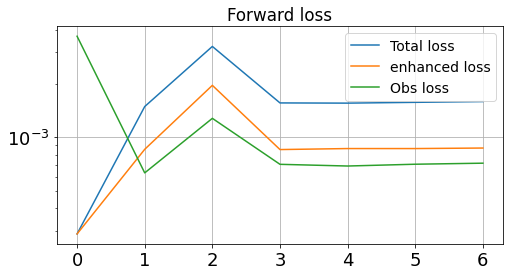

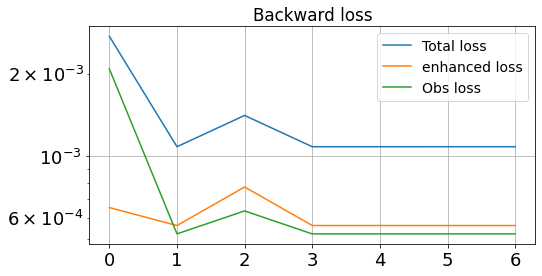

In [ ]:
# plotting loss function 
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])
fig.tight_layout()

0 [0.00150979 0.00046975 0.00288397]
1 [0.00128643 0.00070883 0.0005776 ]
2 [0.00128643 0.00070883 0.0005776 ]
3 [0.00128643 0.00070883 0.0005776 ]
4 [0.00128643 0.00070883 0.0005776 ]
5 [0.00128643 0.00070883 0.0005776 ]
6 [0.00128643 0.00070883 0.0005776 ]


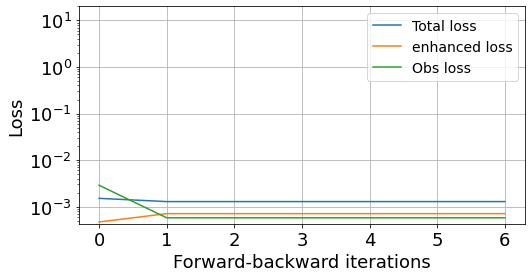

In [ ]:
loss = (np.array(backward_loss)+np.array(forward_loss))/2
new_loss = loss.copy()

# Because we discard the forward-backward iteration with loss greater than the minimum
print(0, new_loss[0,:])
for i in range(1,len(new_loss)):
    if new_loss[i,-1] > new_loss[i-1,-1]:
        new_loss[i,:] = new_loss[i-1,:] 
    print(i, new_loss[i,:])
    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(new_loss)
ax.set_yscale('log')
ax.set_ylim(top=2*10**1)
ax.set_ylabel('Loss') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()
plt.legend(['Total loss','enhanced loss','Obs loss'])

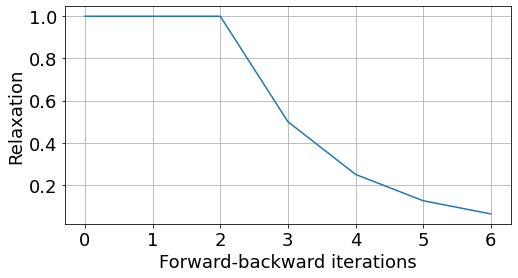

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(list_relax)
ax.set_ylabel('Relaxation') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()

First forward pass

In [ ]:
'''
    Inverse transforms of pca, scaling and splitting of fields/sensor values
    for the initial forward pass.
    Carried out for analysis and evaluation of the model.
'''
split_inv = np.split(X_predict_forward_first, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)

#undoing pca scaling
alpha_unscaled = scaler_pca.inverse_transform(alpha)

X_recovered = pca.inverse_transform(alpha_unscaled)
print("X_recovered shape: ", X_recovered.shape)

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])

norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(455, 43)
GAN shape output of sensor CO2:  (455, 7)
X_recovered shape:  (455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


### BELOW is for testing, purposes - please see the results.ipynb for more complete plots/figures
variable dumps/loads

In [ ]:
joblib.dump(norm_co2_, 'output_files/norm_co2_FirstFwd.pkl')
joblib.dump(norm_x_, 'output_files/norm_x_FirstFwd.pkl')
joblib.dump(norm_y_, 'output_files/norm_y_FirstFwd.pkl')
joblib.dump(norm_z_, 'output_files/norm_z_FirstFwd.pkl')
joblib.dump(norm_sensor_CO2_, 'output_files/norm_sensor_CO2_FirstFwd.pkl')
joblib.dump(DA_scaler, 'output_files/output_pod_files/DA_scaler.pkl')


joblib.dump(X_predict_forward_first, 'output_files/X_predict_forward_first.pkl')
joblib.dump(X_predict_forward_last, 'output_files/X_predict_forward_last.pkl')
joblib.dump(latent_values_onlyPOD, 'output_files/latent_values_onlyPOD.pkl')
# IF need to configure Last Full Pass
joblib.dump(X_predict_backward, 'output_files/X_predict_backward.pkl')
joblib.dump(latent_values, 'output_files/latent_values.pkl')
joblib.dump(alpha_unscaled, 'output_files/alpha_unscaled_FirstFwd.pkl')

['/content/gdrive/MyDrive/ACSE-9/output_DA_files/latent_values_19_08_v2.pkl']

In [ ]:
# latent_values = joblib.load('output_files/latent_values_16_08_v1.pkl')
# X_predict_backward = joblib.load('output_files/X_predict_backward_16_08_v1.pkl')

In [ ]:
# norm_co2_ = joblib.load('output_files/norm_co2_FirstFwd.pkl')
# norm_x_ = joblib.load('output_files/norm_x_FirstFwd.pkl')
# norm_y_ = joblib.load('output_files/norm_y_FirstFwd.pkl')
# norm_z_ = joblib.load('output_files/norm_z_FirstFwd.pkl')
# norm_sensor_CO2_ = joblib.load('output_files/norm_sensor_CO2_FirstFwd.pkl')
# alpha_unscaled = joblib.load('output_files/alpha_unscaled_FirstFwd.pkl')

In [ ]:
'''
  Inverse transforming training dataset
  Splitting of the fields
'''
X_pca_inv = pca.inverse_transform(X_train_pca)
print(X_pca_inv.shape)
real = np.split(X_pca_inv, [int(X_pca_inv.shape[-1]/4), int(X_pca_inv.shape[-1]/2), int(X_pca_inv.shape[-1]*(3/4)), ], axis=1)
print(real[0].shape)
real_co2_ = scaler_std.inverse_transform(real[0])
real_x_ = scaler_x.inverse_transform(real[1])
real_y_ = scaler_y.inverse_transform(real[2])
real_z_ = scaler_z.inverse_transform(real[-1])


(410, 595624)
(410, 148906)


In [ ]:
'''
    Inverse transforms of pca, scaling and splitting of fields/sensor values
    for the final DA pass.
    Carried out for analysis and evaluation of the model.
'''
split_inv = np.split(X_predict_forward_last, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)

#undoing pca scaling
alpha_unscaled_DA = scaler_pca.inverse_transform(alpha)

X_recovered = pca.inverse_transform(alpha_unscaled_DA)
print("X_recovered shape: ", X_recovered.shape)

X_unscaled_DA = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_DA = scaler_std.inverse_transform(X_unscaled_DA[0])
norm_x_DA = scaler_x.inverse_transform(X_unscaled_DA[1])
norm_y_DA = scaler_y.inverse_transform(X_unscaled_DA[2])
norm_z_DA = scaler_z.inverse_transform(X_unscaled_DA[-1])
# norm_sensor_CO2_DA = DA_scaler.inverse_transform(sensor_CO2)
norm_sensor_CO2_DA = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_DA.shape)
print("norm_z_ shape: ", norm_z_DA.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_DA.shape)

(455, 43)
GAN shape output of sensor CO2:  (455, 7)
X_recovered shape:  (455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


In [ ]:
joblib.dump(norm_co2_DA, 'output_files/norm_co2_DA.pkl')
joblib.dump(norm_x_DA, 'output_files/norm_x_DA.pkl')
joblib.dump(norm_y_DA, 'output_files/norm_y_DA.pkl')
joblib.dump(norm_z_DA, 'output_files/norm_z_DA.pkl')
joblib.dump(norm_sensor_CO2_DA, 'output_files/norm_sensor_CO2_DA.pkl')
joblib.dump(alpha_unscaled_DA, 'output_files/alpha_unscaled_DA.pkl')

['/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_sensor_CO2_DA_19_08_v2.pkl']

DA pass with Last

In [ ]:
# norm_co2_DA = joblib.load('output_files/norm_co2_DA.pkl')
# norm_x_DA = joblib.load('output_files/norm_x_DA.pkl')
# norm_y_DA = joblib.load('output_files/norm_y_DA.pkl')
# norm_z_DA = joblib.load('output_files/norm_z_DA.pkl')
# norm_sensor_CO2_DA = joblib.load('output_files/norm_sensor_CO2_DA.pkl')
# alpha_unscaled_DA = joblib.load('output_files/alpha_unscaled_DA.pkl')

### For more complete plots (ones seen in report and more) please see the results.ipynb
last pass

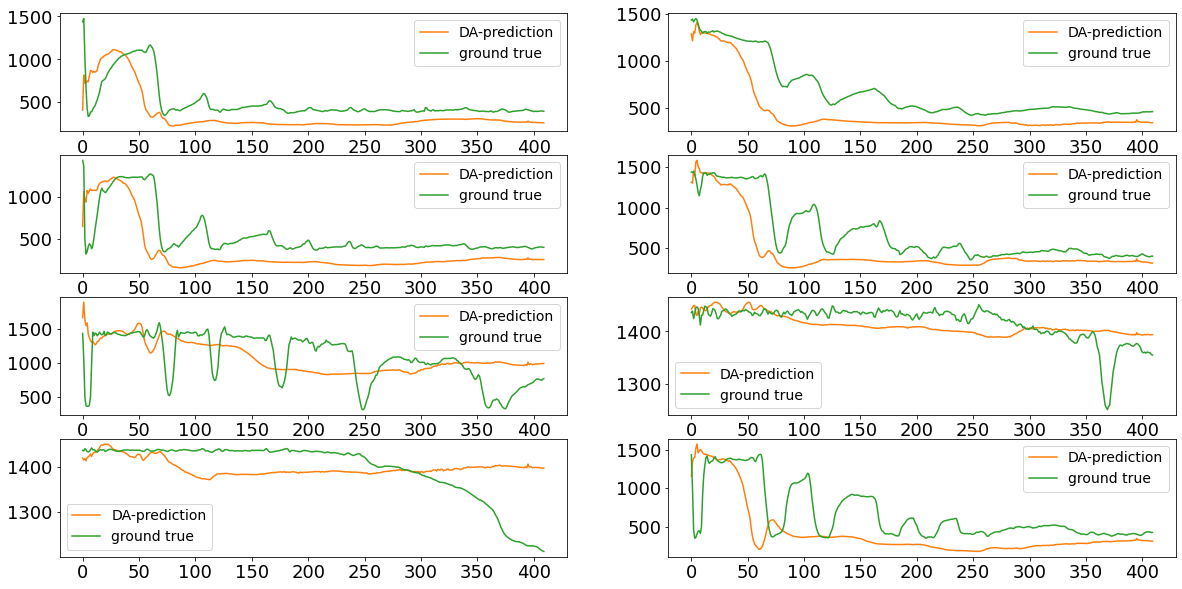

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# 8 nodes -> 0, 100, 200, 300 ...
for i in range(8):

    ax.flatten()[i].plot(norm_co2_DA[:410,i*100], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,i*100], 'C2-')
    
    ax.flatten()[i].legend(['DA-prediction', 'ground true'])

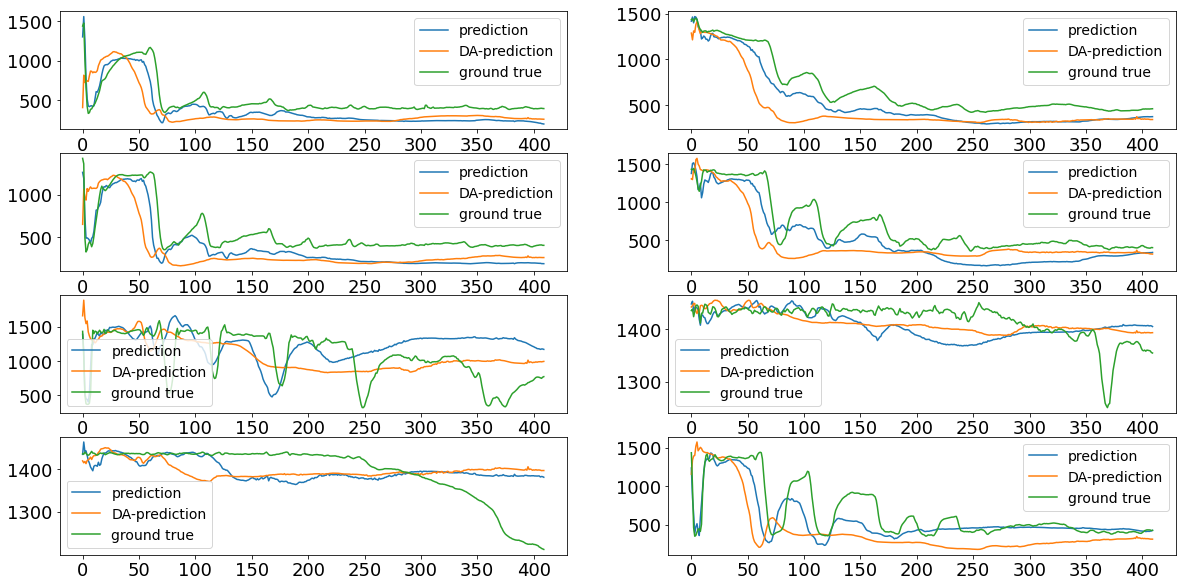

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# 8 nodes -> 0, 100, 200, 300 ...
for i in range(8):

    ax.flatten()[i].plot(norm_co2_[:410,i*100], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,i*100], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,i*100], 'C2-')
    
    ax.flatten()[i].legend(['prediction', 'DA-prediction', 'ground true'])

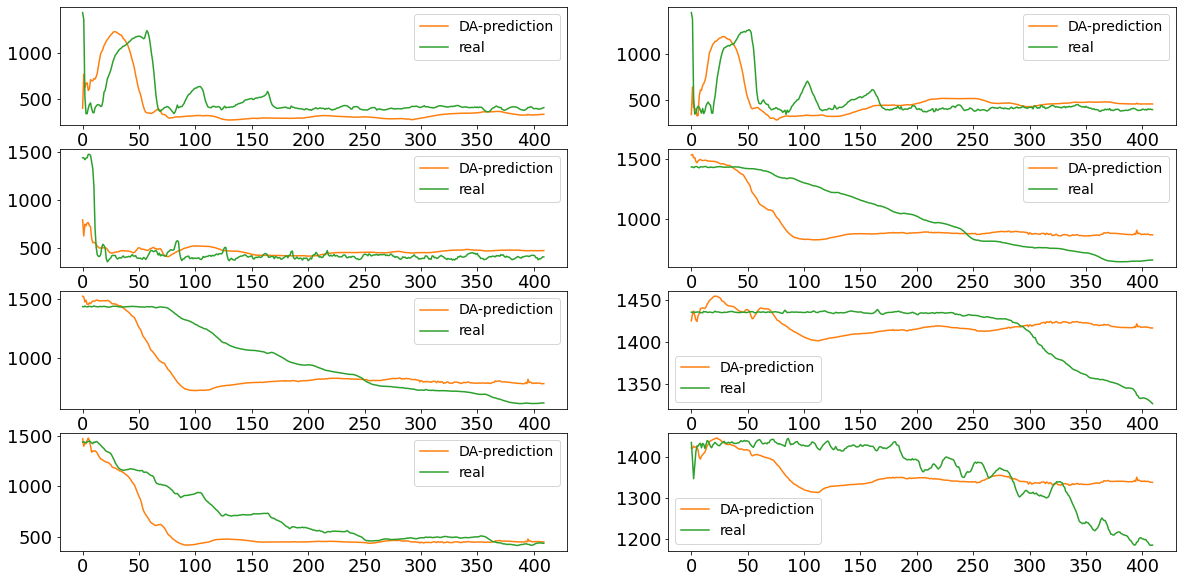

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# closest nodes of sensor location

for i in range(8):
    #ax.flatten()[i].plot(norm_co2_[:410,locs[i]], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,locs[i]], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,locs[i]], 'C2-')
    
    ax.flatten()[i].legend(['DA-prediction', 'real'])

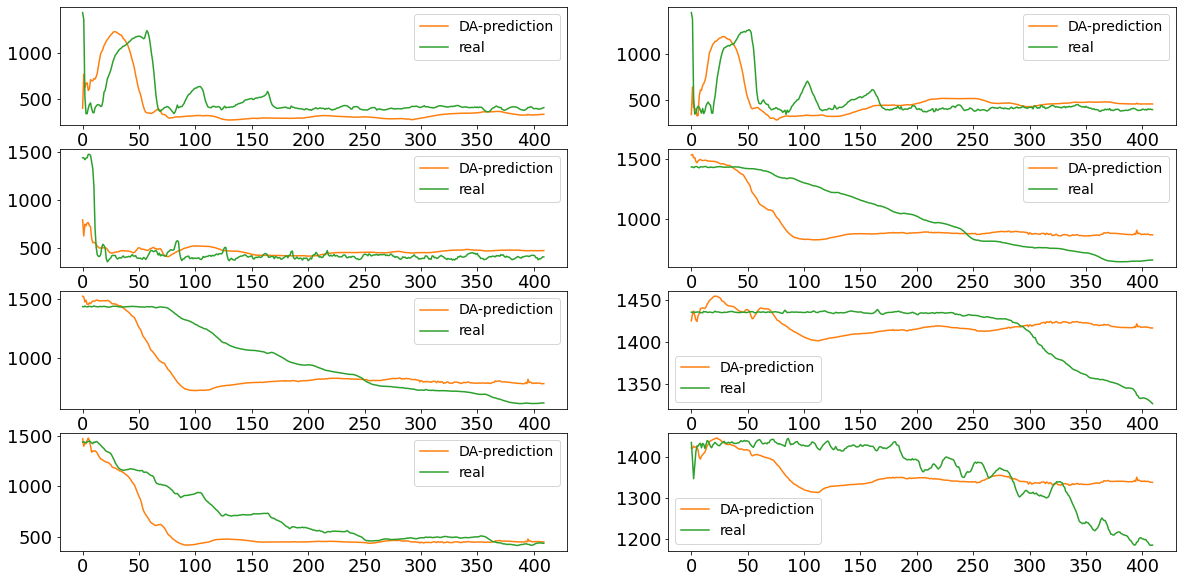

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# closest nodes of sensor location
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

for i in range(8):

    ax.flatten()[i].plot(norm_co2_DA[:410,locs[i]], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,locs[i]], 'C2-')
    
    ax.flatten()[i].legend(['DA-prediction', 'real'])

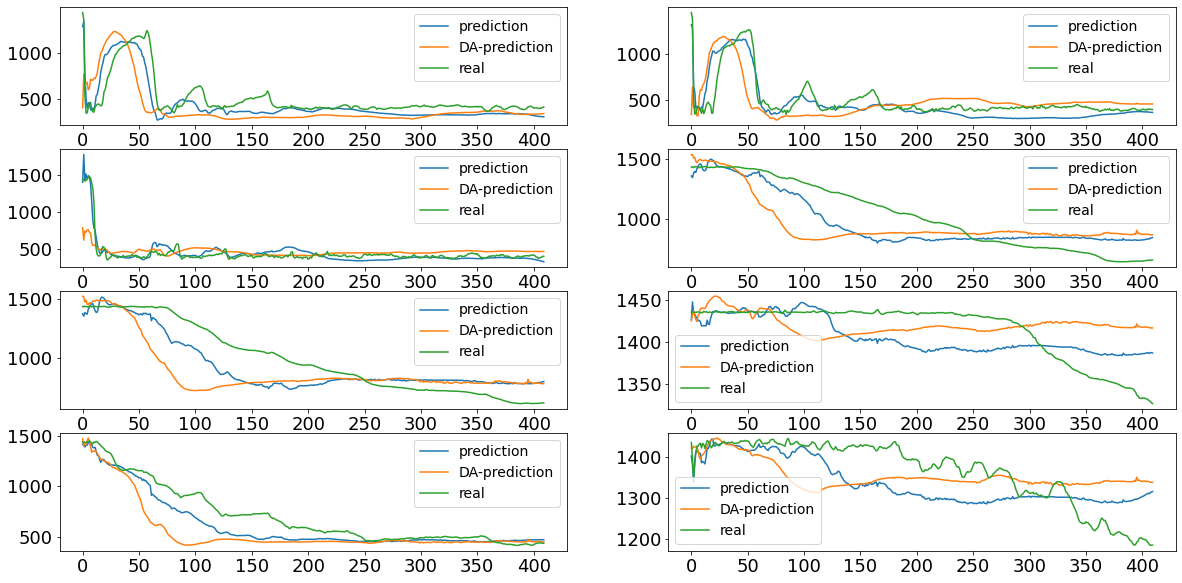

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# close nodes of sensor location
locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

for i in range(8):

    ax.flatten()[i].plot(norm_co2_[:410,locs[i]], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,locs[i]], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,locs[i]], 'C2-')
    
    ax.flatten()[i].legend(['prediction', 'DA-prediction', 'real'])

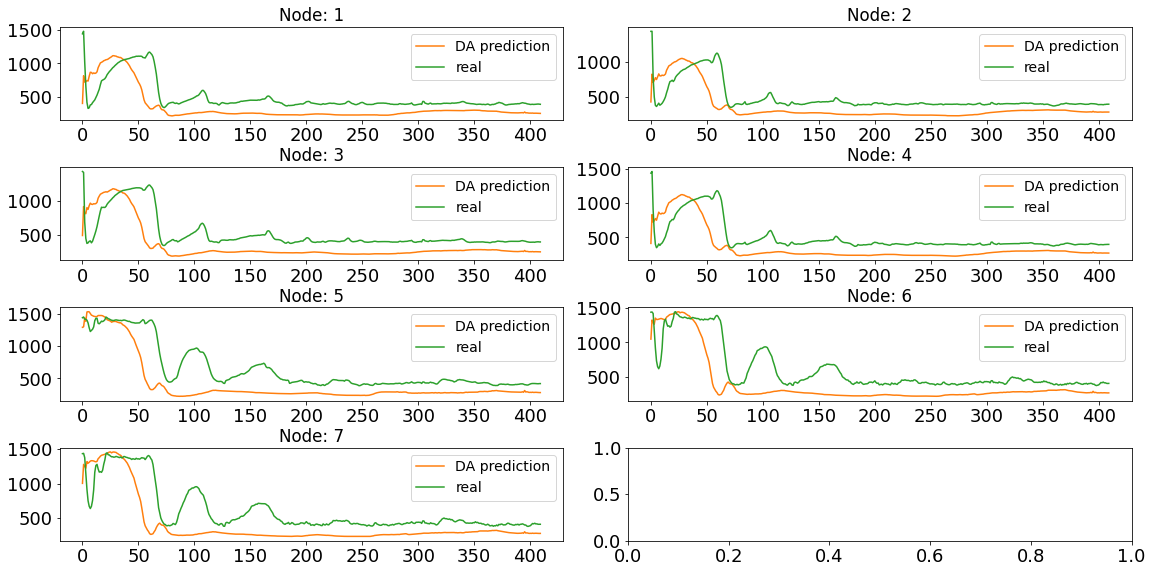

In [ ]:
## real sensor location comparison

# print(C02_sensor_all.min())
# print(norm_sensor_CO2_.min())
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout()
for i in range(7):
    #ax.flatten()[i].plot(norm_co2_[:454,i*100], '-')
    ax.flatten()[i].title.set_text('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_DA[:410,i], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,i], 'C2-')
    ax.flatten()[i].legend(['DA prediction', 'real'])


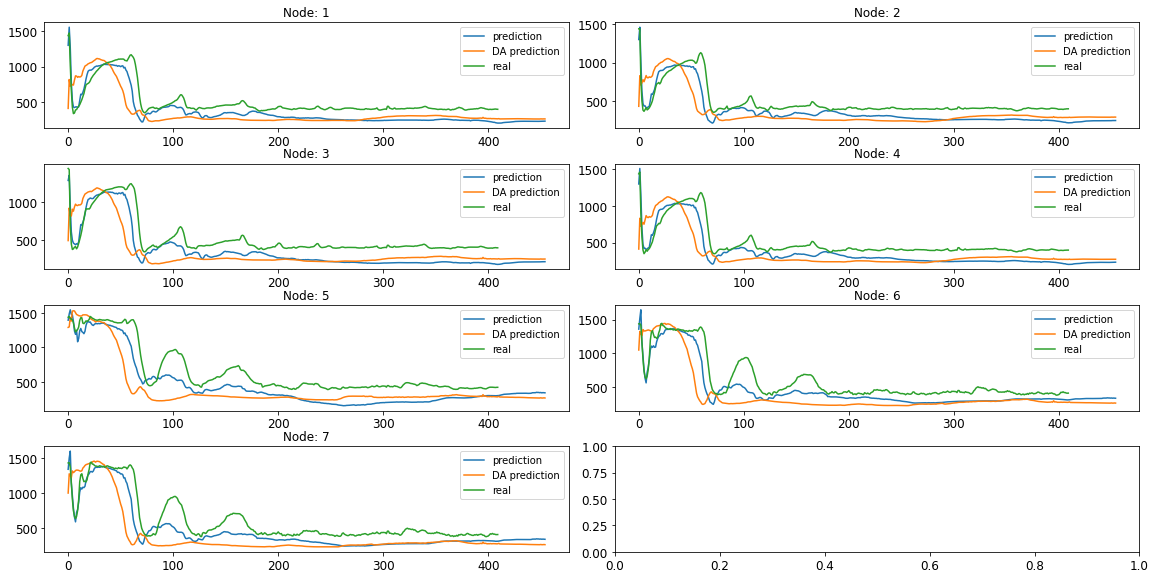

In [ ]:
## real sensor location comparison

# print(C02_sensor_all.min())
# print(norm_sensor_CO2_.min())
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout()
for i in range(7):
    ax.flatten()[i].title.set_text('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_[:,i], '-')
    ax.flatten()[i].plot(norm_co2_DA[:,i], 'C1-')
    ax.flatten()[i].plot(real_co2_[:,i], 'C2-')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

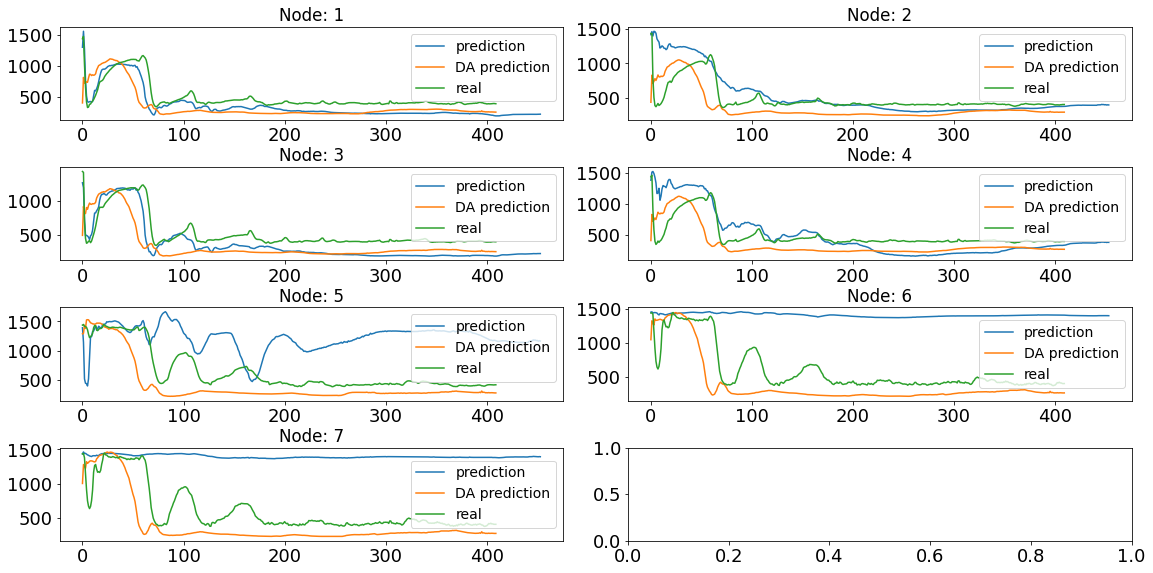

In [ ]:
## real sensor location comparison

fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout()
for i in range(7):
    ax.flatten()[i].title.set_text('Node: {}' .format(i+1))
    ax.flatten()[i].plot(norm_co2_[:454,i*100], '-')
    ax.flatten()[i].plot(norm_co2_DA[:410,i], 'C1-')
    ax.flatten()[i].plot(real_co2_[:410,i], 'C2-')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])


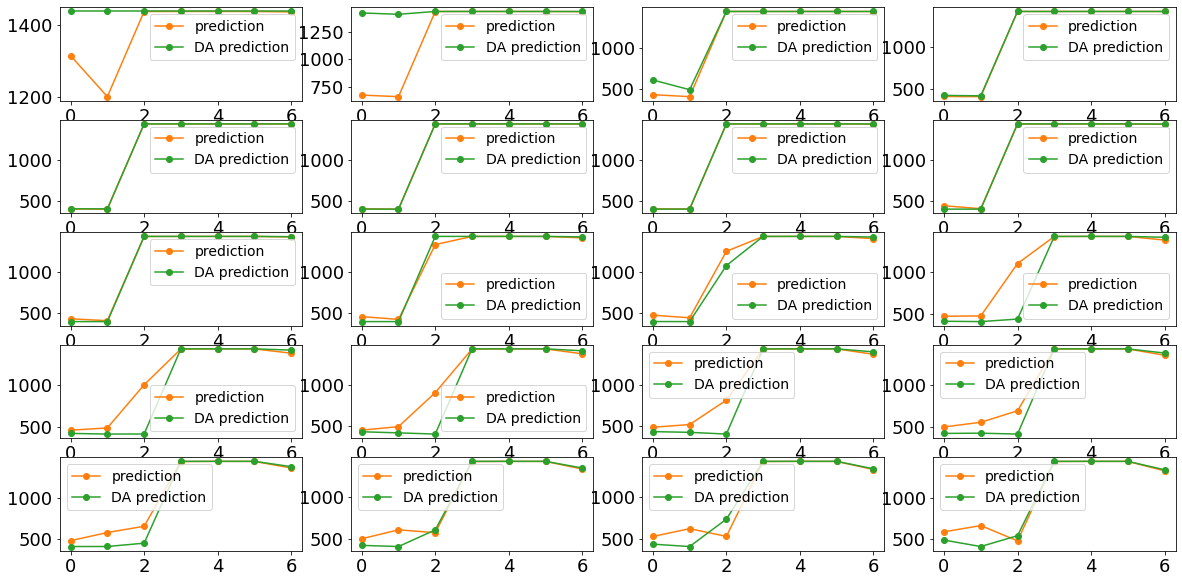

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], 'C2-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

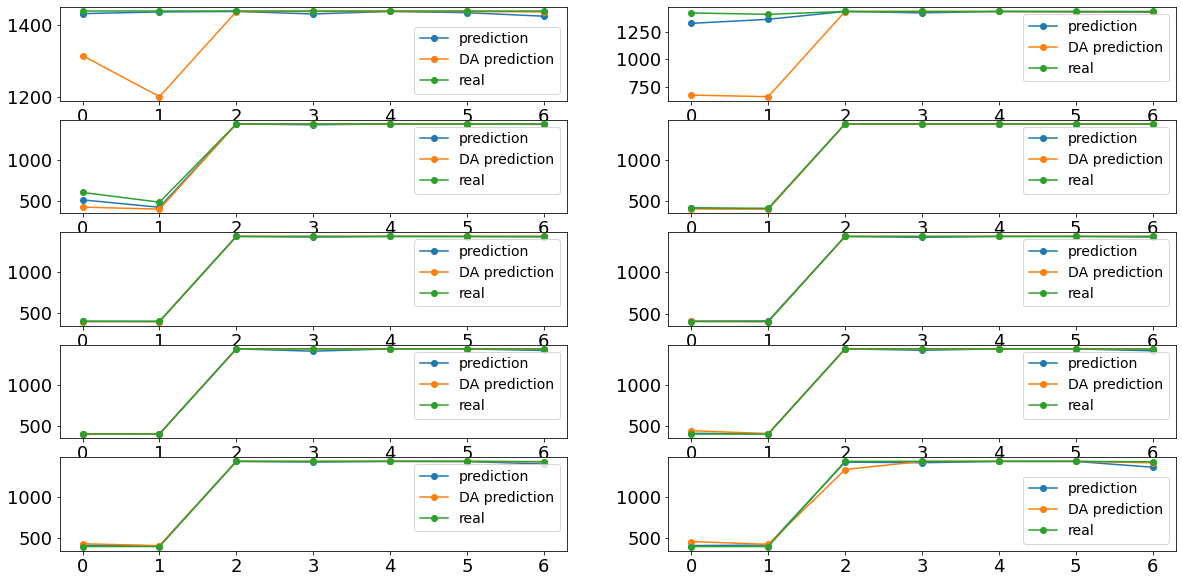

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], 'C2-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

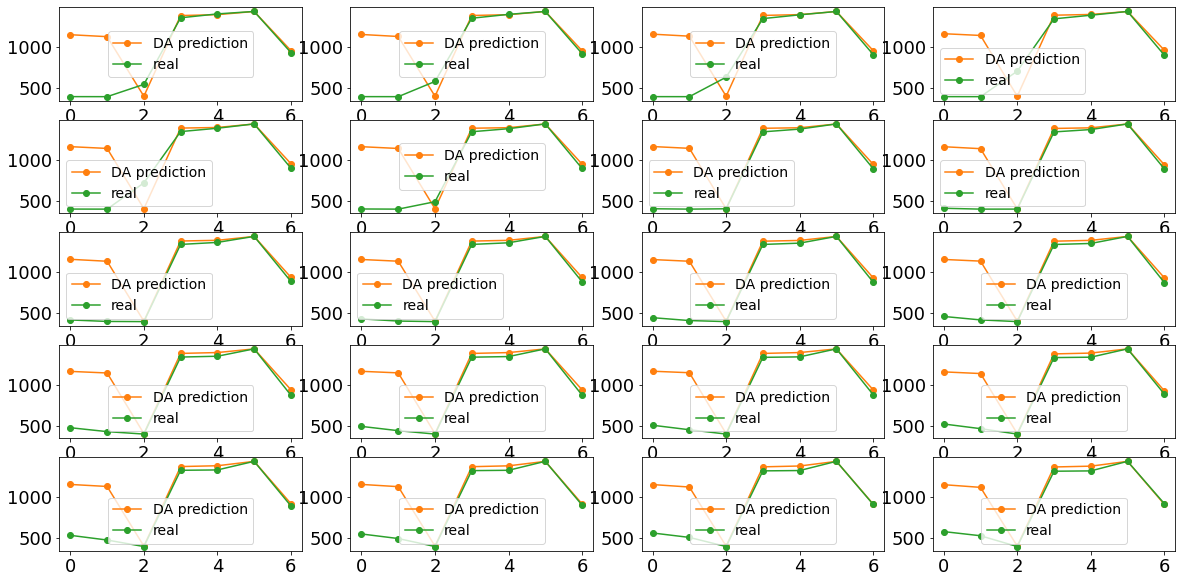

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[80+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[80+i,:], 'C2-o')
    ax.flatten()[i].legend(['DA prediction', 'real'])

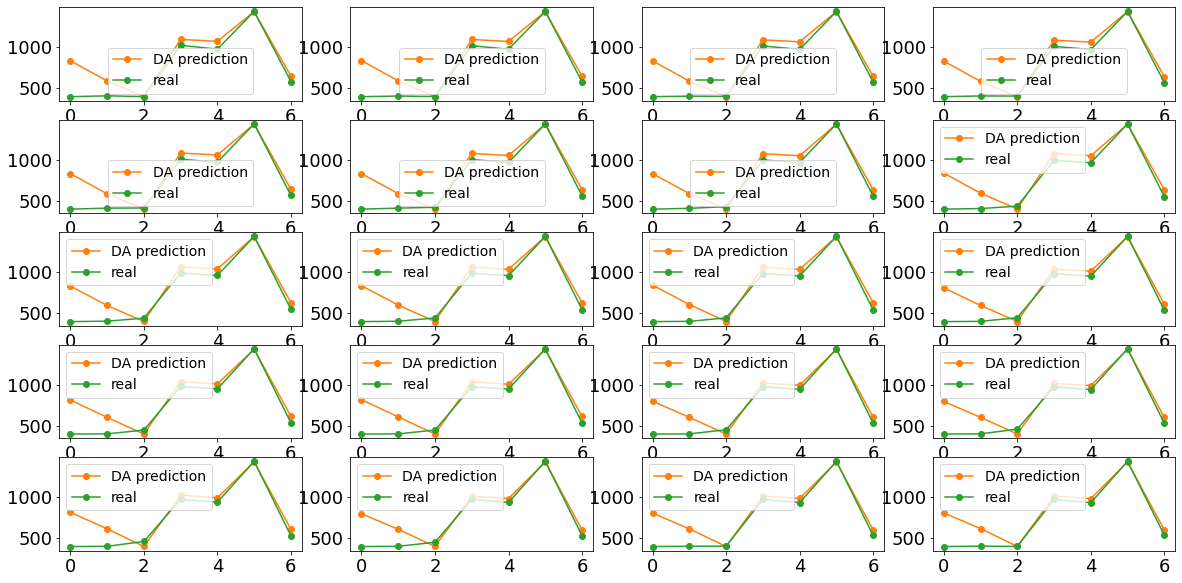

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[200+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], 'C2-o')
    ax.flatten()[i].legend(['DA prediction', 'real'])

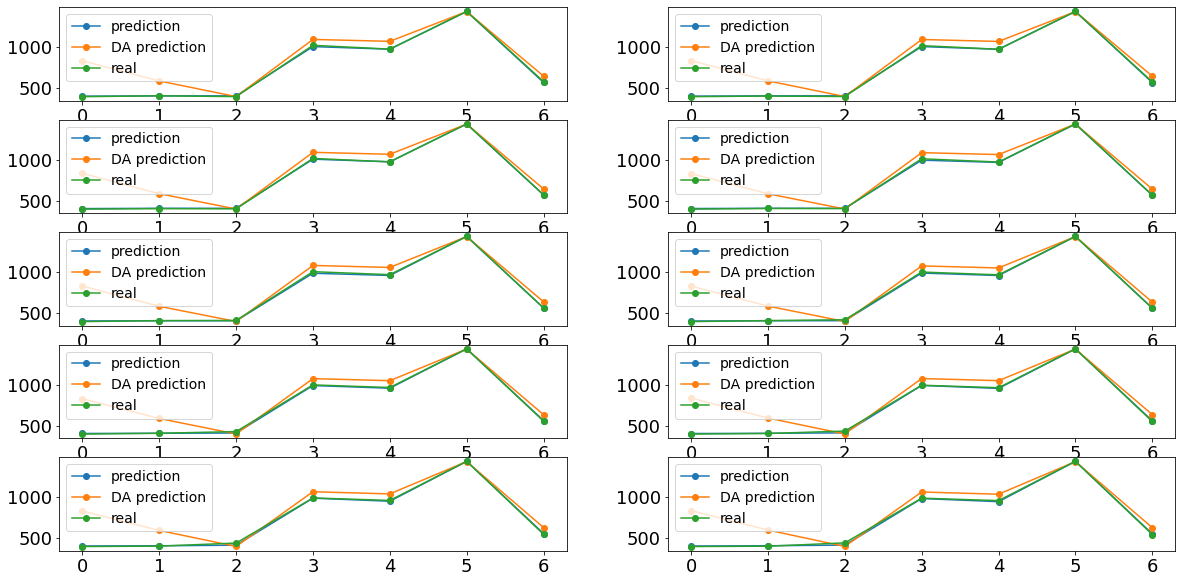

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[200+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], 'C2-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

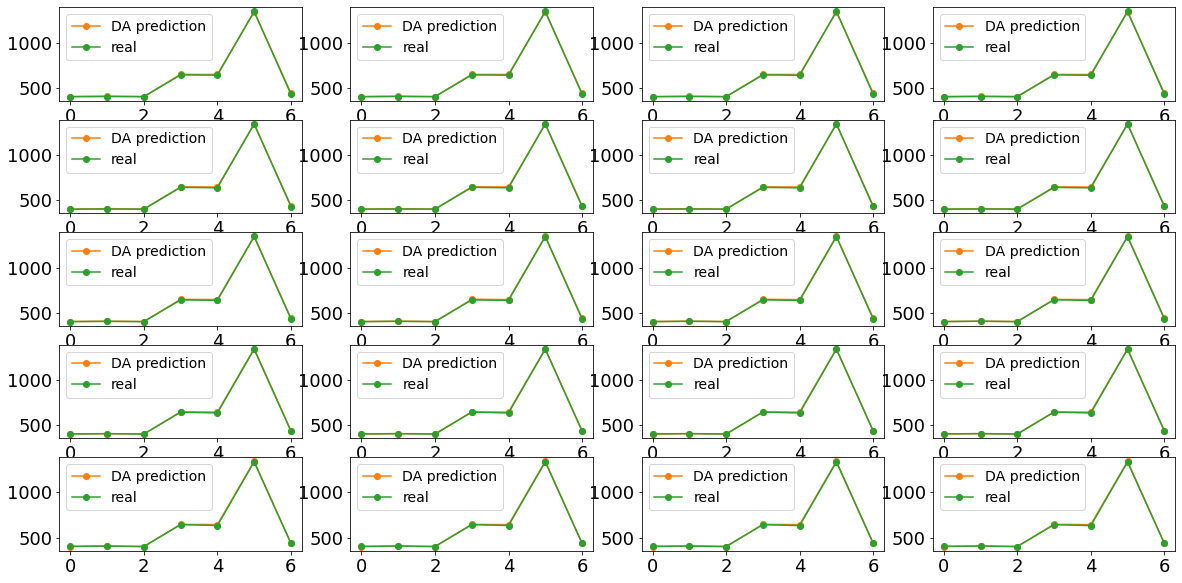

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[390+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], 'C2-o')
    ax.flatten()[i].legend(['DA prediction', 'real'])

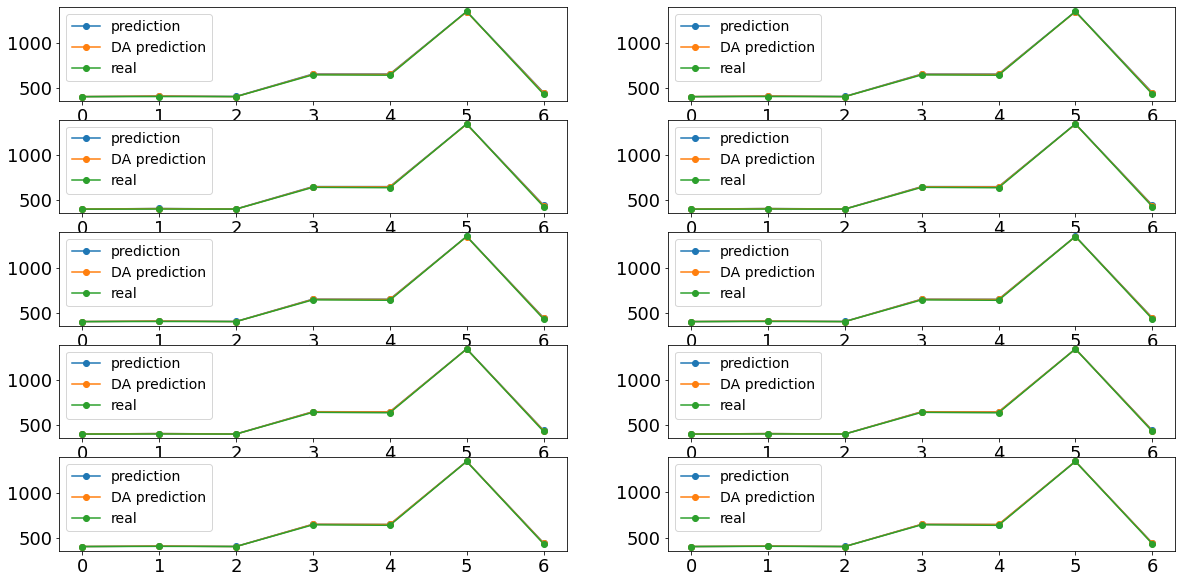

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[390+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], 'C2-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

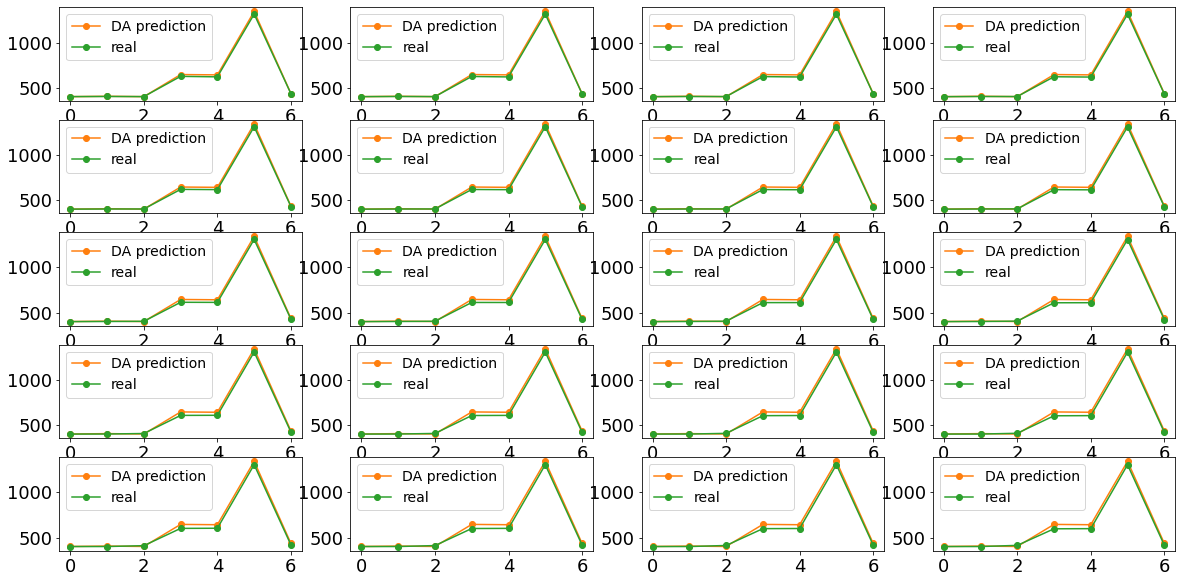

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_DA[435+i,:], 'C1-o')
    ax.flatten()[i].plot(CO2_sensor_all[435+i,:], 'C2-o')
    ax.flatten()[i].legend(['DA prediction', 'real'])

Comparing against experimental data

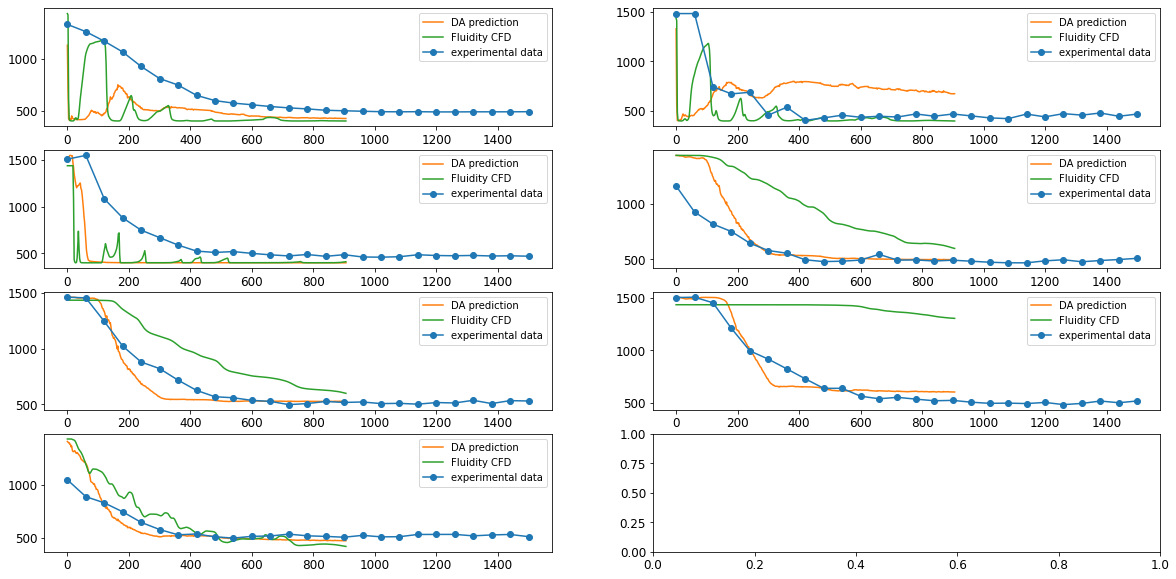

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i in range(7):

  ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_DA[:-1,i], 'C1-')
  ax.flatten()[i].plot(CO2_timevals[0], CO2_sensor_all[:-1,i], 'C2-')
  ax.flatten()[i].plot(CO2_experiment[0], CO2_experiment[i+1, :], 'o-')

  ax.flatten()[i].legend(['DA prediction', 'Fluidity CFD', 'experimental data'])

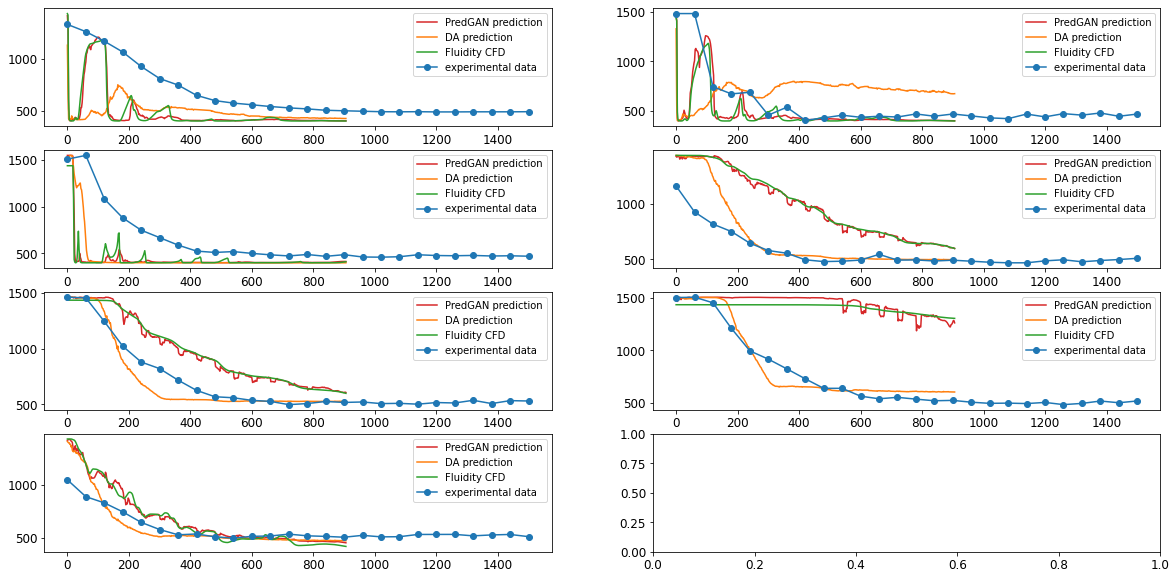

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i in range(7):
  ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_[:-1,i], 'C3-')
  #ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_PredGAN[:-1,i], '-')
  ax.flatten()[i].plot(CO2_timevals[0], norm_sensor_CO2_DA[:-1,i], 'C1-')
  ax.flatten()[i].plot(CO2_timevals[0], CO2_sensor_all[:-1,i], 'C2-')
  ax.flatten()[i].plot(CO2_experiment[0], CO2_experiment[i+1, :], 'o-')

  ax.flatten()[i].legend(['PredGAN prediction', 'DA prediction', 'Fluidity CFD', 'experimental data'])

Writing to .vtu files 
 - uncomment below to save to .vtu files

In [ ]:
# def write_example_to_vtu(exm_num):
#   # get clean vtu file
#   snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
#   snapshot_file_base = 'ClarenceCentre_'
#   filename = snapshot_data_location + snapshot_file_base + '0.vtu'
#   clean_vtu = get_clean_vtu_file(filename)

#   # write results to vtu
#   nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
#   CO2_ppm = np.zeros((nNodes,1))
#   velocity = np.zeros((nNodes,3))
#   # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

#   new_vtu = vtktools.vtu()
#   new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
#   new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/DA-predictions/DA_prediction_' + str(exm_num) + '.vtu'

#   CO2_ppm[:] = norm_co2_DA[exm_num].reshape((148906, 1),order='F')
#   # for j in range(3):
#   velocity[:,0] = norm_x_DA[exm_num].reshape((148906),order='F')
#   velocity[:,1] = norm_y_DA[exm_num].reshape((148906),order='F') 
#   velocity[:,2] = norm_z_DA[exm_num].reshape((148906),order='F')

#   # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


#   new_vtu.AddField('CO2_ppm', CO2_ppm)
#   new_vtu.AddField('Velocity', velocity)
#   #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
#   new_vtu.Write()

In [ ]:
# # writing to vtu file
# tic = time.time()
# nVTU = norm_co2_DA.shape[0]
# for i in range(nVTU):
#   tic = time.time()
#   write_example_to_vtu(i)
#   toc = time.time()
#   print("DA-PredGAN VTU file", i, "written in ", toc - tic, "seconds")
# print("completed")

DA-PredGAN VTU file 0 written in  8.66422414779663 seconds
DA-PredGAN VTU file 1 written in  4.720486879348755 seconds
DA-PredGAN VTU file 2 written in  4.8060784339904785 seconds
DA-PredGAN VTU file 3 written in  5.005850553512573 seconds
DA-PredGAN VTU file 4 written in  4.8241071701049805 seconds
DA-PredGAN VTU file 5 written in  5.015798568725586 seconds
DA-PredGAN VTU file 6 written in  4.7982566356658936 seconds
DA-PredGAN VTU file 7 written in  4.725533723831177 seconds
DA-PredGAN VTU file 8 written in  4.746427059173584 seconds
DA-PredGAN VTU file 9 written in  4.791801691055298 seconds
DA-PredGAN VTU file 10 written in  4.995858669281006 seconds
DA-PredGAN VTU file 11 written in  4.813577175140381 seconds
DA-PredGAN VTU file 12 written in  4.959164619445801 seconds
DA-PredGAN VTU file 13 written in  4.766206741333008 seconds
DA-PredGAN VTU file 14 written in  4.9351794719696045 seconds
DA-PredGAN VTU file 15 written in  4.89423394203186 seconds
DA-PredGAN VTU file 16 written i